In [1]:
import os
import numpy as np
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import librosa
import librosa.display
from IPython.display import Audio, display  # For audio playback

In [2]:
Clean_Data_Directory = r"C:\Users\ashut\SelectiveNoiseReduction_MiniProject_SEM6\DataSet\clean_trainset_28spk_wav"
Noisy_Data_Directory = r"C:\Users\ashut\SelectiveNoiseReduction_MiniProject_SEM6\DataSet\noisy_trainset_28spk_wav"

In [3]:
#Load Audio Data Function
def load_data(Clean_Data_Directory, Noisy_Data_Directory, batch_size=16, max_samples=1000):
    clean_signals, noisy_signals = [], []

    # Load audio files
    clean_files = [f for f in os.listdir(Clean_Data_Directory) if f.endswith('.wav')][:max_samples]
    noisy_files = [f for f in os.listdir(Noisy_Data_Directory) if f.endswith('.wav')][:max_samples]

    for f in tqdm(clean_files, desc="Loading clean files"):
        waveform, _ = torchaudio.load(os.path.join(Clean_Data_Directory, f))
        clean_signals.append(waveform)

    for f in tqdm(noisy_files, desc="Loading noisy files"):
        waveform, _ = torchaudio.load(os.path.join(Noisy_Data_Directory, f))
        noisy_signals.append(waveform)

    # Ensure matching clean and noisy samples
    if len(clean_signals) != len(noisy_signals):
        raise ValueError(f"Mismatch: {len(clean_signals)} clean signals and {len(noisy_signals)} noisy signals.")
    
    # Pad or truncate signals to a common length
    min_length = min(max(s.shape[1] for s in clean_signals), max(s.shape[1] for s in noisy_signals))
    clean_signals_array = [clean[:, :min_length] if clean.shape[1] > min_length else torch.cat([clean, torch.zeros(1, min_length - clean.shape[1])], dim=1) for clean in clean_signals]
    noisy_signals_array = [noisy[:, :min_length] if noisy.shape[1] > min_length else torch.cat([noisy, torch.zeros(1, min_length - noisy.shape[1])], dim=1) for noisy in noisy_signals]

    clean_tensor = torch.stack(clean_signals_array)
    noisy_tensor = torch.stack(noisy_signals_array)
    dataset = TensorDataset(noisy_tensor, clean_tensor)

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
#Speech Enhancement Model
# Define model
class SpeechEnhancementModel(nn.Module):
    def __init__(self):
        super(SpeechEnhancementModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x

In [19]:
#Train Model
# Training function
def train_model(model, dataloader, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_values = []

    for epoch in range(epochs):
        epoch_loss = 0
        for noisy, clean in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        average_loss = epoch_loss / len(dataloader)
        loss_values.append(average_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}")

    return loss_values

In [15]:
import os
print(os.path.exists("C:\\Users\\ashut\\SelectiveNoiseReduction_MiniProject_SEM6\\DataSet\\clean_trainset_28spk_wav\\p226_001.wav"))

True


In [16]:
import torchaudio
torchaudio.set_audio_backend("soundfile")

C:\Users\ashut\AppData\Local\Temp\ipykernel_17360\2654335069.py:2: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


In [17]:
import torchaudio
print(torchaudio.list_audio_backends())

['soundfile']


In [20]:
#Load Data and Initialize model
dataloader = load_data(Clean_Data_Directory, Noisy_Data_Directory, batch_size=8, max_samples=1000)
model = SpeechEnhancementModel()
loss_values = train_model(model, dataloader, epochs=5)

Epoch 1/5: 100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [1/5], Loss: 0.0058


Epoch 2/5: 100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch [2/5], Loss: 0.0003


Epoch 3/5: 100%|██████████| 125/125 [01:53<00:00,  1.10it/s]


Epoch [3/5], Loss: 0.0003


Epoch 4/5: 100%|██████████| 125/125 [02:02<00:00,  1.02it/s]


Epoch [4/5], Loss: 0.0003


Epoch 5/5: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]

Epoch [5/5], Loss: 0.0003


In [21]:
import torch
print("Is CUDA available? ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())
print("Current CUDA device: ", torch.cuda.current_device())
print("CUDA device name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

Is CUDA available?  True
CUDA device count:  1
Current CUDA device:  0
CUDA device name:  NVIDIA GeForce RTX 3050 Laptop GPU


In [22]:
# Save the model
torch.save(model.state_dict(), 'speech_enhancement_model.pth')
print("Model saved as 'speech_enhancement_model.pth'")

Model saved as 'speech_enhancement_model.pth'


In [23]:
# Evaluation metrics calculation
def calculate_metrics(original, enhanced):
    mse = torch.mean((original - enhanced) ** 2).item()
    rmse = np.sqrt(mse)
    psnr = 10 * np.log10(1 / mse) if mse != 0 else float('inf')
    snr = 10 * torch.log10(torch.mean(original ** 2) / torch.mean((original - enhanced) ** 2)).item()
    sdr = snr  # Similar to SNR for non-negative signals in dB

    return {"MSE": mse, "RMSE": rmse, "PSNR": psnr, "SNR": snr, "SDR": sdr}

In [24]:
# Spectrogram plotting
def plot_spectrogram(signal, title='Spectrogram', sr=22050):
    plt.figure(figsize=(10, 4))
    X = librosa.stft(signal.numpy())
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [25]:
# Testing with metrics and visualization
def test_model(model, audio_path):
    model.eval()
    waveform, sr = torchaudio.load(audio_path)
    waveform = waveform.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        enhanced_signal = model(waveform)

    # Original and Enhanced Audio playback
    print("Original Noisy Audio:")
    display(Audio(waveform.squeeze().numpy(), rate=sr))

    print("Enhanced Audio:")
    display(Audio(enhanced_signal.squeeze().numpy(), rate=sr))

    # Plot spectrograms for visual comparison
    plot_spectrogram(waveform.squeeze(), title="Original Noisy Signal Spectrogram")
    plot_spectrogram(enhanced_signal.squeeze(), title="Enhanced Signal Spectrogram")

    # Calculate and display metrics
    metrics = calculate_metrics(waveform.squeeze(), enhanced_signal.squeeze())
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Save enhanced audio
    torchaudio.save('enhanced_output.wav', enhanced_signal.squeeze(0), sr)
    print("Enhanced audio saved as 'enhanced_output.wav'")

Original Noisy Audio:


Enhanced Audio:


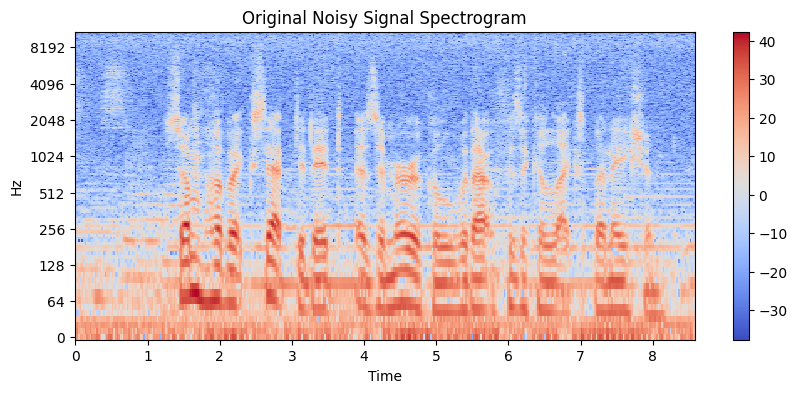

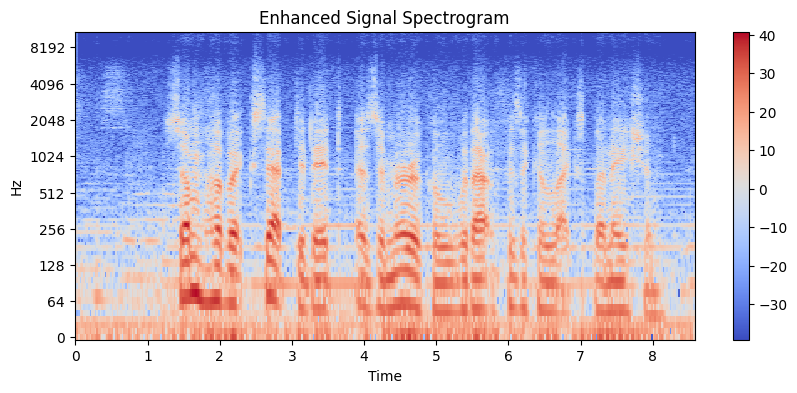


Evaluation Metrics:
MSE: 0.0008
RMSE: 0.0276
PSNR: 31.1676
SNR: 10.4000
SDR: 10.4000
Enhanced audio saved as 'enhanced_output.wav'


In [26]:
# Example usage
test_audio_path = r"C:\Users\ashut\SelectiveNoiseReduction_MiniProject_SEM6\DataSet\noisy_testset_wav\p232_013.wav"
test_model(model, test_audio_path)